## Dissertation Data Cleaning v2
### Gavin Rolls

This is a new version of my data cleaning document now that I've extracted some different building types. I want to create a dataframe that unifies a lot of the different approaches I've taken to make data handling easier

## Imports

In [78]:
#Basics
import pandas as pd
import geopandas as gpd

#Shapely
from geopy.geocoders import Nominatim
from shapely.geometry import box
from shapely import wkt
import shapely.geometry
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import mapping
from shapely.geometry import shape

#Plots
import matplotlib.pyplot as plt

#Warning Supression
import warnings

## Data Loading + Cleaning

### UK BRES Employment Data

In [80]:
#Skip the first six rows because they're header information
empl_data = pd.read_csv('data/employment_data/lsoa_by_industry_london.csv', skiprows=7, delimiter=',')

unnamed_cols = empl_data.columns[empl_data.columns.str.contains('^Unnamed:')]
empl_data.drop(columns=unnamed_cols, inplace=True)

#Separate name into LSOA11CD and LSOA11NM
def split_column(value):
    #Keep Greater London stats
    if value.startswith('gor:'):
        return value, value
        #Split into name and code
    else:
        parts = value.split('lsoa2011:')[1]
        code, name = parts.split(' : ')
        return code.strip(), name.strip()
        return code, name

empl_data[['LSOA11CD', 'LSOA11NM']] = empl_data['Area'].apply(lambda x: pd.Series(split_column(x)))

print("Num Rows (LSOAs) Before Cleaning: " + str(empl_data.shape[0]))

#There appear to be a bunch of duplicates so I'm going to get rid of them now
empl_data.drop_duplicates(inplace=True)

print("Num Rows (LSOAs) After Cleaning: " + str(empl_data.shape[0]))

Num Rows (LSOAs) Before Cleaning: 9478
Num Rows (LSOAs) After Cleaning: 4836


In [82]:
#Create Total Employment Column
empl_data['total_employment'] = empl_data[empl_data.columns[1:-2]].sum(axis=1)

empl_data.head()

,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,07 : Mining of metal ores,08 : Other mining and quarrying,09 : Mining support service activities,10 : Manufacture of food products,...,93 : Sports activities and amusement and recreation activities,94 : Activities of membership organisations,95 : Repair of computers and personal and household goods,96 : Other personal service activities,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11CD,LSOA11NM,total_employment
0,gor:London,1250,1250,400,0,1500,0,450,350,32000,...,56000,57000,17000,62000,0,0,0,gor:London,gor:London,5605320
1,lsoa2011:E01000907 : Camden 001A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,E01000907,Camden 001A,115
2,lsoa2011:E01000908 : Camden 001B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,E01000908,Camden 001B,180
3,lsoa2011:E01000909 : Camden 001C,0,0,0,0,0,0,0,0,0,...,0,0,0,5,0,0,0,E01000909,Camden 001C,200
4,lsoa2011:E01000912 : Camden 001D,0,0,0,0,0,0,0,0,0,...,0,0,0,5,0,0,0,E01000912,Camden 001D,825


### LSOA Geographic Data

In [84]:
#Get London LSOA Shapefile Data
lsoa_geo = gpd.read_file('data/lsoa_data/LSOA_2011_London_gen_MHW.shp')

#Convert to WGS for consistency
lsoa_geo = lsoa_geo.to_crs(epsg=4326)
lsoa_geo = lsoa_geo.drop(lsoa_geo.columns[list(range(3, 8))], axis = 1)

print("Num Rows (LSOAs): " + str(lsoa_geo.shape[0]))

#Get rid of columns I'm not using for now
lsoa_geo = lsoa_geo.drop(columns=['MSOA11CD', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'])
lsoa_geo = lsoa_geo.rename(columns={'USUALRES': 'population'})

lsoa_geo.head()

Num Rows (LSOAs): 4835


,LSOA11CD,LSOA11NM,population,geometry
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027..."
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752..."
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282..."
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974..."
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ..."


### Overture Places Data

In [86]:
overture_places = gpd.read_file('data/overture_data/london_places_overture.geojson')

print('Number of POIs in Overture (London): ' + str(overture_places.shape[0]))
overture_places.head()

Number of POIs in Overture (London): 343712


,name,category,confidence,geometry
0,The Heating Professionals,hvac_services,0.77,POINT (-0.50991 51.28709)
1,Hub Property Care,plumbing,0.77,POINT (-0.50991 51.28709)
2,F & S,plumbing,0.72,POINT (-0.50911 51.28766)
3,Hookins Accountants,accountant,0.75,POINT (-0.50881 51.28878)
4,Muddy Paws Grooming Service,pet_groomer,0.55,POINT (-0.50741 51.28859)


NOTE - I'm going to skip overture buildings because they're comparatively bad as we've aleady established

### OpenStreetMap Buildings Data

I will query each set of building types and then collapse the dataset down so that tags are preserved

In [87]:
osm_all_buildings = gpd.read_file('data/osm_data/all_london_buildings.geojson')

print('Number of Buildings in OSM (London): ' + str(osm_all_buildings.shape[0]))
osm_all_buildings.head()

Number of Buildings in OSM (London): 970140


,element_type,osmid,name,geometry
0,way,2956186,Laurence House,"POLYGON ((-0.02162 51.44472, -0.02033 51.44469..."
1,way,2956187,Lewisham Town Hall,"POLYGON ((-0.02108 51.44524, -0.02122 51.44516..."
2,way,2956188,Broadway Theatre,"POLYGON ((-0.02004 51.44536, -0.02003 51.44532..."
3,way,2956192,JD Sports,"POLYGON ((-0.01903 51.44462, -0.01903 51.44461..."
4,way,2956193,Air Thrill,"POLYGON ((-0.01752 51.44542, -0.01815 51.44551..."


In [88]:
# Commercial Buildings

osm_commercial_buildings = gpd.read_file('data/osm_data/all_london_commercial_buildings.geojson')

print('Number of Commercial Buildings in OSM (London): ' + str(osm_commercial_buildings.shape[0]))
osm_commercial_buildings.head()

Number of Commercial Buildings in OSM (London): 7156


,element_type,osmid,name,geometry
0,way,4076571,Bromley Road Retail Park,"POLYGON ((-0.02063 51.43669, -0.02047 51.43631..."
1,way,4076587,Catford Delivery Office,"POLYGON ((-0.02001 51.43859, -0.02004 51.43865..."
2,way,5790535,Refuge House,"POLYGON ((-0.07800 51.65301, -0.07777 51.65303..."
3,way,5986754,One Canada Square,"POLYGON ((-0.02002 51.50477, -0.01996 51.50500..."
4,way,5987126,None,"POLYGON ((-0.02588 51.50520, -0.02596 51.50531..."


In [89]:
# Office Buildings

osm_office_buildings = gpd.read_file('data/osm_data/all_london_office_buildings.geojson')

print('Number of Office Buildings in OSM (London): ' + str(osm_office_buildings.shape[0]))
osm_office_buildings.head()

Number of Office Buildings in OSM (London): 3683


,element_type,osmid,name,geometry
0,way,4237383,ITN,"POLYGON ((-0.11445 51.52304, -0.11478 51.52344..."
1,way,5251705,None,"POLYGON ((-0.23366 51.40761, -0.23281 51.40822..."
2,way,5986805,HSBC UK,"POLYGON ((-0.01792 51.50522, -0.01794 51.50525..."
3,way,5986920,KPMG,"POLYGON ((-0.01680 51.50508, -0.01663 51.50569..."
4,way,5986929,Barclays,"POLYGON ((-0.01494 51.50486, -0.01493 51.50490..."


In [90]:
# Residential Buildings

osm_residential_buildings = gpd.read_file('data/osm_data/all_london_residential_buildings.geojson')

print('Number of Residential Buildings in OSM (London): ' + str(osm_residential_buildings.shape[0]))
osm_residential_buildings.head()

Number of Residential Buildings in OSM (London): 85730


,element_type,osmid,name,geometry
0,way,4948114,Kemble House,"POLYGON ((-0.10656 51.46576, -0.10645 51.46582..."
1,way,4948116,Kettleby House,"POLYGON ((-0.10571 51.46618, -0.10559 51.46624..."
2,way,4948118,Woolley House,"POLYGON ((-0.10486 51.46659, -0.10473 51.46665..."
3,way,5131193,None,"POLYGON ((-0.19992 51.46981, -0.19992 51.46987..."
4,way,5131194,None,"POLYGON ((-0.19955 51.46940, -0.19955 51.46980..."


In [91]:
# Retail Buildings

osm_retail_buildings = gpd.read_file('data/osm_data/all_london_retail_buildings.geojson')

print('Number of Retail Buildings in OSM (London): ' + str(osm_retail_buildings.shape[0]))
osm_retail_buildings.head()

Number of Retail Buildings in OSM (London): 13609


,element_type,osmid,name,geometry
0,way,4270351,None,"POLYGON ((-0.03794 51.63273, -0.03778 51.63280..."
1,way,4425414,None,"POLYGON ((-0.21897 51.57513, -0.21821 51.57486..."
2,way,4425469,None,"POLYGON ((-0.23039 51.57118, -0.22974 51.57071..."
3,way,4770296,Kingston Rowing Club / Tiffin School Boat Club,"POLYGON ((-0.30581 51.41876, -0.30566 51.41905..."
4,way,4775619,St Richard's Court,"POLYGON ((-0.32066 51.43665, -0.32049 51.43647..."


I have a hard time believing that only ~ 1/10th of buildings in London are residential but we'll verify once we start plotting some LSOAs to see what the results look like

In [92]:
# Assign a building type in the main DataFrame if the osmid is found in one of the other DataFrames

# I know that office and retail buildings could have commercial or office but office and retail will overwrite commercia
# (and are thus checked after) because they're more specific

osm_all_buildings['building_type'] = 'none'

osm_all_buildings.loc[osm_all_buildings['osmid'].isin(osm_commercial_buildings['osmid']), 'building_type'] = 'commercial'
osm_all_buildings.loc[osm_all_buildings['osmid'].isin(osm_retail_buildings['osmid']), 'building_type'] = 'retail'
osm_all_buildings.loc[osm_all_buildings['osmid'].isin(osm_office_buildings['osmid']), 'building_type'] = 'office'
osm_all_buildings.loc[osm_all_buildings['osmid'].isin(osm_residential_buildings['osmid']), 'building_type'] = 'residential'

osm_all_buildings.head(50)

,element_type,osmid,name,geometry,building_type
0,way,2956186,Laurence House,"POLYGON ((-0.02162 51.44472, -0.02033 51.44469...",none
1,way,2956187,Lewisham Town Hall,"POLYGON ((-0.02108 51.44524, -0.02122 51.44516...",none
2,way,2956188,Broadway Theatre,"POLYGON ((-0.02004 51.44536, -0.02003 51.44532...",none
3,way,2956192,JD Sports,"POLYGON ((-0.01903 51.44462, -0.01903 51.44461...",none
4,way,2956193,Air Thrill,"POLYGON ((-0.01752 51.44542, -0.01815 51.44551...",none
5,way,2956281,Malling,"POLYGON ((-0.01541 51.45391, -0.01539 51.45396...",none
6,way,2956282,Bredgar,"POLYGON ((-0.01524 51.45350, -0.01526 51.45346...",none
7,way,4038655,Bestway Wholesalers,"POLYGON ((0.00644 51.44394, 0.00770 51.44274, ...",none
8,way,4075885,Homebase,"POLYGON ((-0.01179 51.42715, -0.01198 51.42709...",none
9,way,4075889,Green Man Community Hub,"POLYGON ((-0.01040 51.42745, -0.01066 51.42729...",none


## Data Joining + Prep

### Joining LSOA Geography and Employment Data

In [93]:
#Note that total London statistics are dropped here because there's no equivalent column in lsoa_geo
empl_geog = pd.merge(lsoa_geo, empl_data, on = "LSOA11CD")

print("Num Rows (LSOAS): " + str(empl_geog.shape[0]))

empl_geog.head()

Num Rows (LSOAS): 4835


,LSOA11CD,LSOA11NM_x,population,geometry,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,...,92 : Gambling and betting activities,93 : Sports activities and amusement and recreation activities,94 : Activities of membership organisations,95 : Repair of computers and personal and household goods,96 : Other personal service activities,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11NM_y,total_employment
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,...,0,125,400,10,10,0,0,0,City of London 001A,14360
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,...,0,100,300,0,35,0,0,0,City of London 001B,45605
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,...,0,20,10,0,10,0,0,0,City of London 001C,760
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,...,20,40,100,150,35,0,0,0,City of London 001E,22735
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Barking and Dagenham 016A,105


### Add POI and Building Data

In [108]:
#Dealing with filter warnings for empty geometries in particular LSOAs
warnings.filterwarnings("ignore", category=FutureWarning)

#Init Columns (This was causing an error at first when I didn't put it here to begin)
empl_geog['num_buildings'] = 0
empl_geog['num_retail_buildings'] = 0
empl_geog['num_residential_buildings'] = 0
empl_geog['num_commercial_buildings'] = 0
empl_geog['num_office_buildings'] = 0

empl_geog['num_places'] = 0

empl_geog['building_poly'] = None
empl_geog['commercial_building_poly'] = None
empl_geog['retail_building_poly'] = None
empl_geog['office_building_poly'] = None
empl_geog['residential_building_poly'] = None

empl_geog['place_points'] = None
empl_geog['category_list'] = None

#Iterate through all LSOAs and grab OSM building counts and subcategories - add to empl_geog dataframe

for index, row in empl_geog.iterrows():

    #Status report
    if (index % 20 == 0):
        print(index)
    
    geom = row['geometry']
    filter_geom = gpd.GeoSeries([geom], crs=lsoa_geo.crs)

    #All Buildings - OSM
    filtered_osm_buildings = osm_all_buildings[osm_all_buildings.geometry.intersects(filter_geom.unary_union)]

    #Get subcategories based on tags
    commercial_buildings = osm_all_buildings[osm_all_buildings['building_type'] == 'commercial']
    office_buildings = osm_all_buildings[osm_all_buildings['building_type'] == 'office']
    retail_buildings = osm_all_buildings[osm_all_buildings['building_type'] == 'retail']
    residential_buildings = osm_all_buildings[osm_all_buildings['building_type'] == 'residential']

    #Subcategories of each building
    filtered_commercial_buildings = commercial_buildings[commercial_buildings.geometry.intersects(filter_geom.unary_union)]
    filtered_office_buildings = office_buildings[office_buildings.geometry.intersects(filter_geom.unary_union)]
    filtered_retail_buildings = retail_buildings[retail_buildings.geometry.intersects(filter_geom.unary_union)]
    filtered_residential_buildings = residential_buildings[residential_buildings.geometry.intersects(filter_geom.unary_union)]

    #Multipolygon of each LSOA's (OSM) buildings - category separated
    combined_multipolygon = filtered_osm_buildings.geometry.unary_union
    combined_commercial_multipolygon = filtered_commercial_buildings.geometry.unary_union
    combined_office_polygon = filtered_office_buildings.geometry.unary_union
    combined_retail_polygon = filtered_retail_buildings.geometry.unary_union
    combined_residential_polygon = filtered_residential_buildings.geometry.unary_union
    
    #All Places
    filtered_places = overture_places[overture_places.geometry.intersects(filter_geom.unary_union)]

    #Multipoint of each LSOA's places
    combined_multipoint = filtered_places.geometry.unary_union
    
    #Add place category information
    category_list = filtered_places['category'].dropna().tolist()
    

    #Add back to Dataframe
    empl_geog.at[index, 'num_buildings'] = len(filtered_osm_buildings)
    
    empl_geog['num_retail_buildings'] = len(filtered_retail_buildings)
    empl_geog['num_residential_buildings'] = len(filtered_residential_buildings)
    empl_geog['num_commercial_buildings'] = len(filtered_commercial_buildings)
    empl_geog['num_office_buildings'] = len(filtered_office_buildings)
    
    empl_geog.at[index, 'num_places'] = len(filtered_places)
    
    empl_geog.at[index, 'building_poly'] = combined_multipolygon
    empl_geog.at[index, 'commercial_building_poly'] = combined_commercial_multipolygon
    empl_geog.at[index, 'retail_building_poly'] = combined_office_polygon
    empl_geog.at[index, 'office_building_poly'] = combined_retail_polygon
    empl_geog.at[index, 'residential_building_poly'] = combined_residential_polygon

    
    empl_geog.at[index, 'place_points'] = combined_multipoint
    empl_geog.at[index, 'category_list'] = category_list
    
#Check
empl_geog.head()

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4

,LSOA11CD,LSOA11NM_x,population,geometry,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,...,category_list,num_buildings,num_retail_buildings,num_residential_buildings,num_commercial_buildings,num_office_buildings,commercial_building_poly,retail_building_poly,office_building_poly,residential_building_poly
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,...,"[pub, coffee_shop, immigration_law, shared_off...",86,0,0,0,0,None,None,None,"MULTIPOLYGON (((-0.0983297 51.5158158, -0.0983..."
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,...,"[business_manufacturing_and_supply, education,...",96,0,0,0,0,None,None,None,"MULTIPOLYGON (((-0.0945314 51.5147658, -0.0944..."
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,...,"[health_and_medical, hospital, parking, indust...",29,0,0,0,0,None,None,None,"MULTIPOLYGON (((-0.0959637 51.5209148, -0.0959..."
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,...,"[professional_services, dance_club, insurance_...",133,0,0,0,0,None,None,None,"MULTIPOLYGON (((-0.0780669 51.5145373, -0.0778..."
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,...,"[landmark_and_historical_building, constructio...",280,0,0,0,0,None,None,None,None


In [110]:
#Save to Dataframe on Desktop

#Convert multipolygons to WKT for export
empl_geog['building_poly'] = empl_geog['building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)
empl_geog['commercial_building_poly'] = empl_geog['commercial_building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)
empl_geog['retail_building_poly'] = empl_geog['retail_building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)
empl_geog['office_building_poly'] = empl_geog['office_building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)
empl_geog['residential_building_poly'] = empl_geog['residential_building_poly'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)

empl_geog['place_points'] = empl_geog['place_points'].apply(lambda x: x.wkt if isinstance(x, shapely.geometry.base.BaseGeometry) else x)

# Convert category_list to string for export
empl_geog['category_list'] = empl_geog['category_list'].apply(lambda x: str(x) if x else None)

#Export
empl_geog.to_file("data/combined_data_v2/empl_geog.geojson", driver="GeoJSON")

In [119]:
# Set back to Geometries for use in plot

# WKT strings back to Shapely geometries
empl_geog['building_poly'] = empl_geog['building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['commercial_building_poly'] = empl_geog['commercial_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['retail_building_poly'] = empl_geog['retail_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['office_building_poly'] = empl_geog['office_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)
empl_geog['residential_building_poly'] = empl_geog['residential_building_poly'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)

empl_geog['place_points'] = empl_geog['place_points'].apply(lambda x: shapely.wkt.loads(x) if isinstance(x, str) else x)

## Plot Check

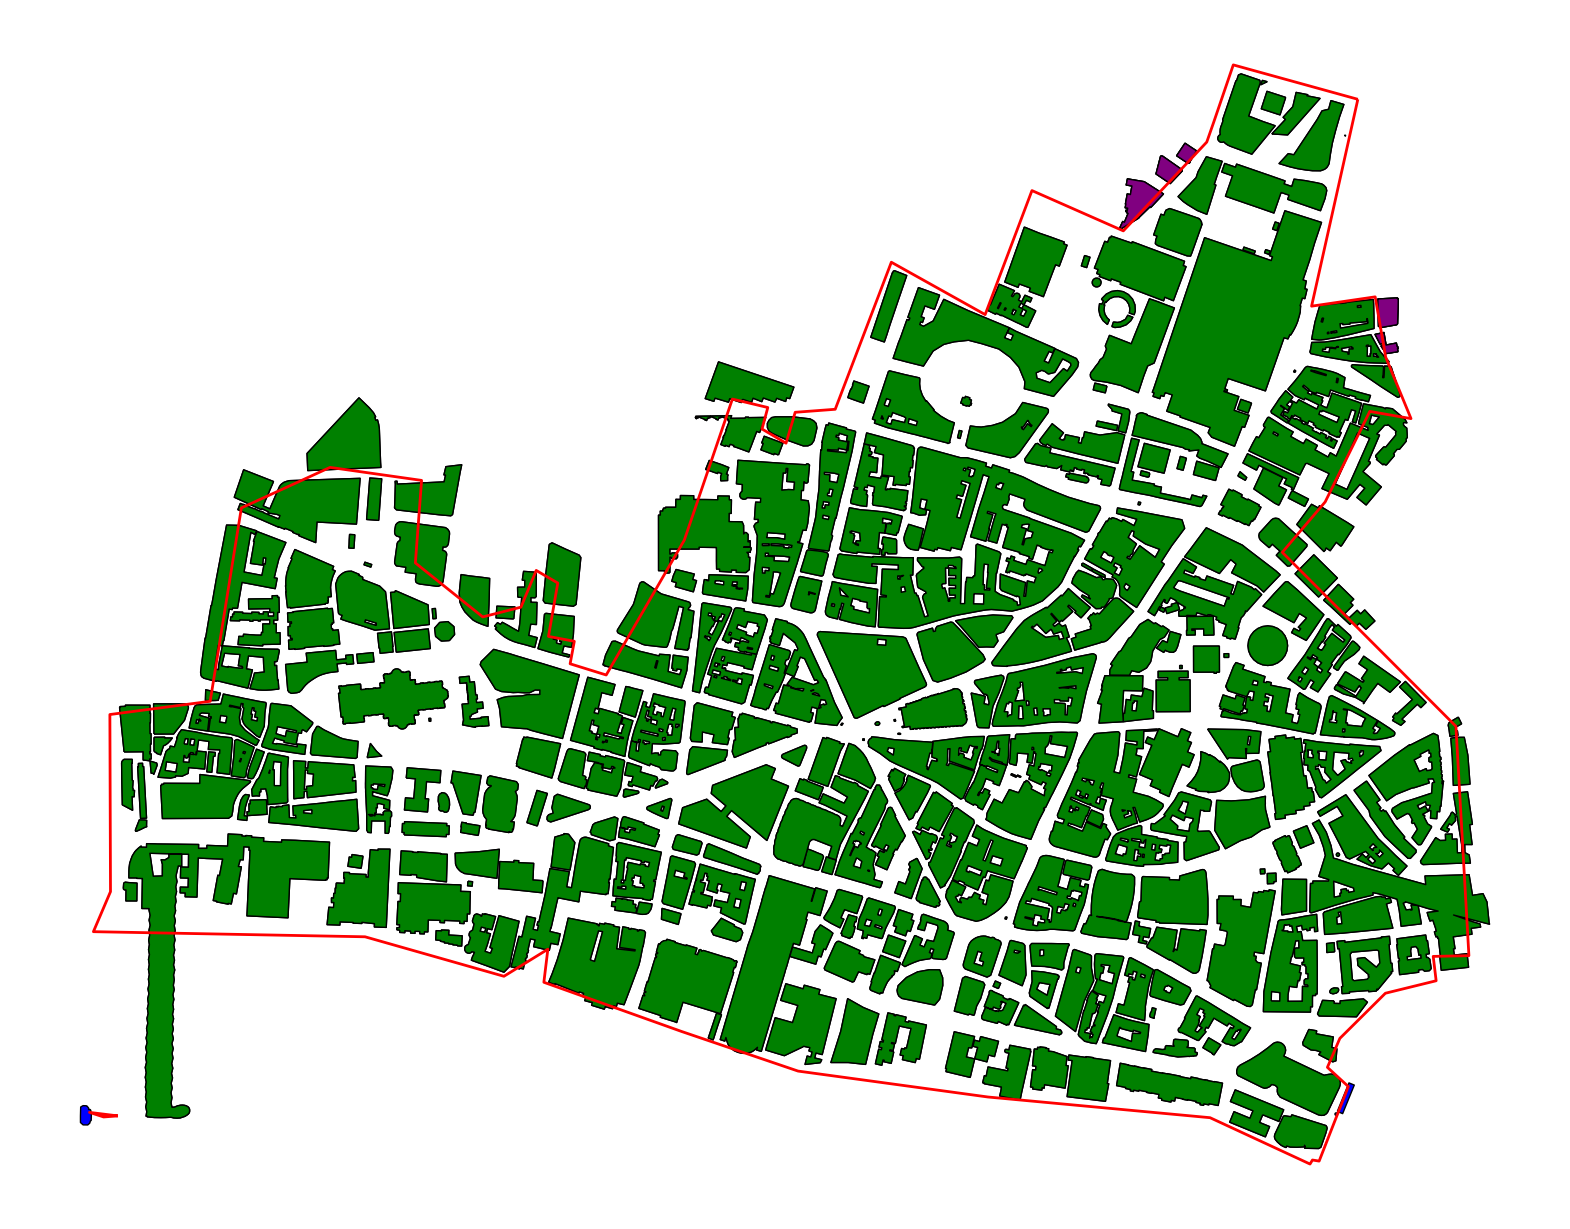

In [167]:
#Get building subset - City of London 001F

#Code from earlier - isolate City of London 001F
lsoa = empl_geog[empl_geog['LSOA11NM_x'] == 'City of London 001F']
geom = lsoa['geometry'].iloc[0]
filter_geom = gpd.GeoSeries([geom], crs=lsoa_geo.crs)

#Get buildings
lsoa_all_buildings = gpd.GeoDataFrame(lsoa, geometry='building_poly')
lsoa_commercial_buildings = gpd.GeoDataFrame(lsoa, geometry='commercial_building_poly')
lsoa_office_buildings = gpd.GeoDataFrame(lsoa, geometry='office_building_poly')
lsoa_residential_buildings = gpd.GeoDataFrame(lsoa, geometry='residential_building_poly')
lsoa_retail_buildings = gpd.GeoDataFrame(lsoa, geometry='retail_building_poly')

# Plot OSM buildings
fig, ax = plt.subplots(figsize=(20, 20))
lsoa_all_buildings.plot(ax=ax, legend=True, color='blue', edgecolor='black')
lsoa_commercial_buildings.plot(ax=ax, legend=True, color='orange', edgecolor='black')
lsoa_office_buildings.plot(ax=ax, legend=True, color='red', edgecolor='black')
lsoa_residential_buildings.plot(ax=ax, legend=True, color='green', edgecolor='black')
lsoa_commercial_buildings.plot(ax=ax, legend=True, color='purple', edgecolor='black')

filter_geom.boundary.plot(ax=ax, color='red', linewidth=2)
ax.set_axis_off()
plt.show()

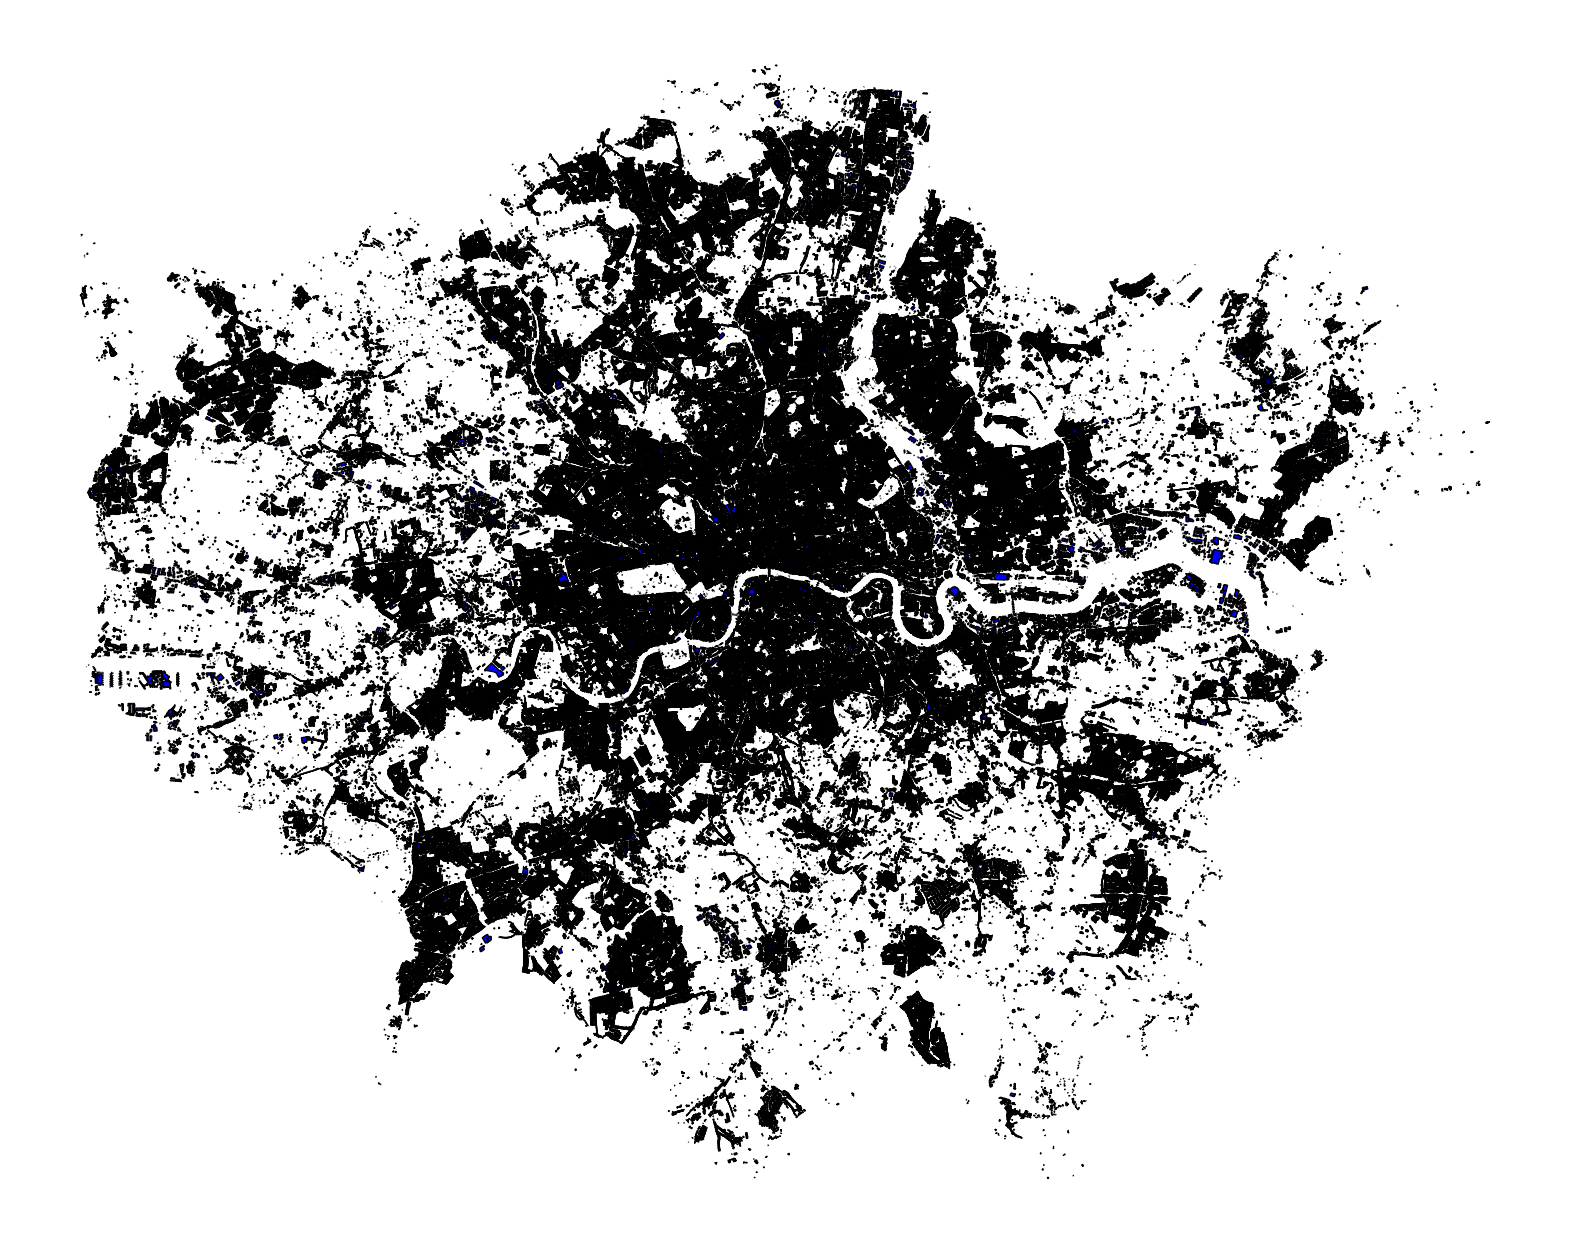

In [171]:
#Get all London

# Plot OSM buildings
fig, ax = plt.subplots(figsize=(20, 20))
osm_office_buildings.plot(ax=ax, legend=True, color='blue', edgecolor='black')
ax.set_axis_off()
plt.show()